In [5]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV

In [6]:
df = pd.read_csv('C:/Users/think/Downloads/tot_daily_df_interpolate.csv')
df.set_index('DATE',inplace=True)
df.dropna(how='any',inplace=True)

In [12]:
# Only the diff of 'T10Y2Y', 'DGS10','RU3000TRReturn', 'UNRATE' are stationary, but we don't need stationary for OLS and feature selection
'''
for i in ['T10Y2Y','DGS10','RU3000TRReturn','UNRATE']:
    df['diff'+i]=pd.DataFrame(df[i].diff(periods=1))
print (df.columns)
df.dropna(how='any',inplace=True)
'''

"\nfor i in ['T10Y2Y','DGS10','RU3000TRReturn','UNRATE']:\n    df['diff'+i]=pd.DataFrame(df[i].diff(periods=1))\nprint (df.columns)\ndf.dropna(how='any',inplace=True)\n"

In [13]:
# Test for stationary with ADF test
adfResult=[]
for c in df.columns:
    adfTest = adfuller(df[c], autolag='AIC')
    adfResult.append(pd.Series(adfTest[0:4]))
adfResults=pd.concat(adfResult,axis=1,sort=False)
adfResults.columns=df.columns
adfResults.index= ['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used']
print (adfResults)

                          T10Y2Y        DGS10       AAA10Y       VIXCLS  \
ADF Test Statistic     -1.638230    -1.755908    -3.043184    -4.647704   
P-Value                 0.463186     0.402561     0.031054     0.000105   
# Lags Used             5.000000     7.000000    21.000000    35.000000   
# Observations Used  6733.000000  6731.000000  6717.000000  6703.000000   

                       GoldReturn  DCOILWTICOReturn  NASDAQ100Return  \
ADF Test Statistic  -1.643694e+01        -19.115509    -1.451530e+01   
P-Value              2.448325e-29          0.000000     5.637766e-27   
# Lags Used          2.900000e+01         16.000000     2.600000e+01   
# Observations Used  6.709000e+03       6722.000000     6.712000e+03   

                     RU2000PRReturn  RU3000TRReturn       UNRATE  \
ADF Test Statistic    -1.449996e+01       -1.966044    -1.088968   
P-Value                5.954743e-27        0.301657     0.719451   
# Lags Used            3.200000e+01       25.000000    35.0

In [14]:
# Detect Collinearity, delete all fratures with vif>5 one by one
vif = pd.DataFrame()
dfnew=df.drop('AAA10Y',axis=1)
vif["VIF Factor"] = [variance_inflation_factor(dfnew.values, i) for i in range(dfnew.shape[1])]
vif["features"] = dfnew.columns
print (vif)

vif = pd.DataFrame()
dfnew=dfnew.drop('UNRATE',axis=1)
vif["VIF Factor"] = [variance_inflation_factor(dfnew.values, i) for i in range(dfnew.shape[1])]
vif["features"] = dfnew.columns
print (vif)

vif = pd.DataFrame()
dfnew=dfnew.drop('VIXCLS',axis=1)
vif["VIF Factor"] = [variance_inflation_factor(dfnew.values, i) for i in range(dfnew.shape[1])]
vif["features"] = dfnew.columns
print (vif)

vif = pd.DataFrame()
dfnew=dfnew.drop('RU3000TRReturn',axis=1)
vif["VIF Factor"] = [variance_inflation_factor(dfnew.values, i) for i in range(dfnew.shape[1])]
vif["features"] = dfnew.columns
print (vif)

    VIF Factor          features
0     7.774515            T10Y2Y
1     6.643860             DGS10
2    11.826009            VIXCLS
3     1.004308        GoldReturn
4     1.044560  DCOILWTICOReturn
5     2.402582   NASDAQ100Return
6     2.491236    RU2000PRReturn
7    11.991107    RU3000TRReturn
8    26.306097            UNRATE
9     1.875412      BUSINVReturn
10    2.025225    CPIAUCSLReturn
   VIF Factor          features
0    2.617686            T10Y2Y
1    5.517197             DGS10
2   11.113350            VIXCLS
3    1.004263        GoldReturn
4    1.044538  DCOILWTICOReturn
5    2.402574   NASDAQ100Return
6    2.490578    RU2000PRReturn
7   10.873024    RU3000TRReturn
8    1.787624      BUSINVReturn
9    2.006611    CPIAUCSLReturn
   VIF Factor          features
0    2.355783            T10Y2Y
1    4.693292             DGS10
2    1.003960        GoldReturn
3    1.044457  DCOILWTICOReturn
4    2.402503   NASDAQ100Return
5    2.455965    RU2000PRReturn
6    5.368091    RU3000TRRet

In [15]:
# Feature Selection with LASSO, we want the features with coef not zero
X1, y=df.drop('AAA10Y',axis=1),df['AAA10Y']
X=dfnew
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
coef = pd.Series(model_lasso.coef_, index = X.columns)
print (coef)
# final answer: T10Y2Y,DGS10,BUSINVReturn

T10Y2Y              0.190924
DGS10              -0.119744
GoldReturn         -0.000000
DCOILWTICOReturn   -0.000000
NASDAQ100Return    -0.000000
RU2000PRReturn     -0.000000
BUSINVReturn       -9.048723
CPIAUCSLReturn     -0.000000
dtype: float64


C:\Users\think\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([1.        , 0.99757872, 0.99531594, 0.99303554, 0.990792  ,
       0.98849305, 0.98628473, 0.98410824, 0.98183015, 0.97947487,
       0.97697384])

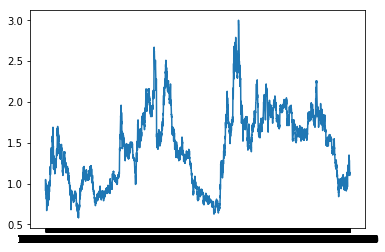

In [4]:
import matplotlib.pyplot as plt
plt.plot (df['AAA10Y'])
acf(df['AAA10Y'],nlags = 10)

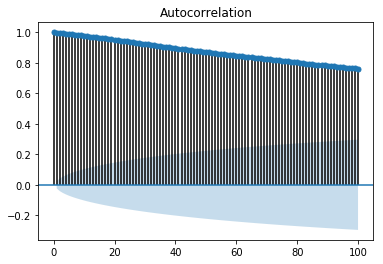

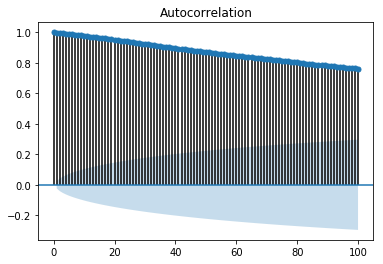

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
acf(df['AAA10Y'],nlags = 100)
plot_acf(df['AAA10Y'],lags = 100)

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
pacf(df['AAA10Y'],nlags = 10)
plot_pacf(df['AAA10Y'],lags = 10)

In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('C:/Users/think/Downloads/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('C:/Users/think/Downloads/pollution1.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0



The following command must be run outside of the IPython shell:

    $ pip install --upgrade tensorflow

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [ ]:
#LSTM 
# convert series to supervised learning
from pandas import *
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('C:/Users/think/Downloads/pollution1.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
from sklearn.preprocessing import *

encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())


# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


from keras.models import Sequential
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Using TensorFlow backend.


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import